# Definição do Problema

## Objetivo

Por meio de redes neurais artificiais convolucionais (CNNs), busca-se realizar classificação multiclasse de imagens contendo diferentes animais.

## Conjunto de dados

O conjunto pode ser obtido [aqui](https://www.kaggle.com/datasets/alessiocorrado99/animals10).

Há dez tipos distintos de animais, sendo eles o cão, o cavalo, o elefante, a borboleta, a galinha, o gato, a vaca, a ovelha, a aranha e o esquilo, cada qual contendo suas respectivas variantes macho e fêmea. Trata-se de um conjunto com cerca de 26k exemplos, previamente rotulados, homogeneamente distribuído entre sete das dez classes, enquanto três delas apresentam quantia de instâncias significativamente superior às demais (vide gráfico na seção de "Leitura do conjunto de dados"). Ainda, em relação à composição desses dados, os exemplos se caracterizam, disjuntamente, como imagens conceituais, fotos, pinturas digitais e demais tipos visuais, embora a distribuição seja desconhecida para esse caso -- dada a falta de rotulação nesse sentido.

A saber, as imagens capturam os animais em diferentes ângulos, por vezes priorizando uma ou outra característica deles -- como, por exemplo, as asas para a borboleta, e as patas de um elefante, que visualmente se diferem em relação aos corpos dos demais animais. Além disso, algumas imagens contêm diversas ocorrências de um mesmo animal, como uma foto contendo uma ninhada de cães. Quanto aos planos de fundo, não há constância para as classes, de tal maneira que se torne seguro classificar tais animais sem ter de recorrer à análise do ambiente para isso; por exemplo, há fotos de esquilos em árvores e em solos coberto por folhas, mas também em ambientes urbanos e em telas planas.

Por fim, a divisão do conjunto de dados é realizada de forma pseudoaleatória, com semente fixa, por meio da técnica de Holdout. Desse modo, o referido conjunto é dividido nos subconjuntos de treino, de validação e de teste, cada qual com 80%, 10% e 10% da quantia absoluta de exemplos respectivamente. Para tanto, uma ferramenta utilitária do Keras será utilizada.

## Conceituação

Trata-se de um problema de classificação multiclasse por meio de aprendizado supervisionado. Ainda, por utilizar redes neurais artificiais, caracteriza-se como um paradigma conexionista, que será descrito por instâncias e aprenderá de forma incremental. Por conseguinte, não há descrição por meio de tabelas atributo-valor: ao invés disso, as características dos dados serão seus três canais (RGB), que são representados por matrizes de pixels, de modo aos modelos neurais inferirem novas características e realizarem o processo classificativo a partir de suas hipóteses.

## Plano de execução

Após a leitura e o pré-processamento dos dados, serão treinados cinco diferentes modelos neurais: um modelo denso, um modelo convolucional com poucas camadas, e as arquiteturas Xception, ResNet50 e InceptionV3. Para cada modelo, serão tomados os resultados que, ao final, serão comparados entre si. Ainda, será feita uma abordagem de visualização para compreensão do modo de extração de características por parte dos modelos convolucionais.


# Aquisição do conjunto de dados

Para execução em ambiente Google Colaboratory.

Para execução local, faça o download e o desempacotamento da base de dados no diretório deste notebook, 
no interior de uma pasta denominada "data". Caso não exista, crie uma. Ao final, é necessário que os 
dados estejam em ./data/raw-img/

In [1]:
# Download do pacote do Kaggle
! pip install -q kaggle

In [ ]:
# Em sua conta do Kaggle, gere uma chave de API: isso fornecerá 
# um arquivo "kaggle.json". Faça upload dele nesta célula
from google.colab import files
files.upload()

In [3]:
# Processamento da licença
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Importação do conjunto de dados
! kaggle datasets download 'alessiocorrado99/animals10'

100% 584M/586M [00:27<00:00, 23.3MB/s]
100% 586M/586M [00:27<00:00, 22.2MB/s]


In [5]:
%%capture

# Unzip dos dados
! mkdir data
! unzip animals10.zip -d data

# Dependências

In [6]:
# Para ciência de dados
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, save_model, load_model
from sklearn.model_selection import train_test_split

# Manipulação de arquivos
import os

# Para mostrar gráficos e imagens
from matplotlib import pyplot as plt
from IPython.display import Image, display
plt.style.use("bmh")

In [7]:
# Verifica se a GPU está sendo utilizada e aplica a expansão memorial
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Quantia de GPUs disponíveis:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Quantia de GPUs disponíveis: 1


# Leitura do conjunto de dados

In [8]:
# Tradução de nomes presente em "./data/translate.py"
translation_mapper = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Para mapeamento das labels
label_mapper = dict([(name, idx) for idx, name in enumerate(translation_mapper)])
label_unmapper = dict([(idx, name) for idx, name in enumerate(translation_mapper.values())])

# Diretório das imagens
IMG_DIR_PATH = "./data/raw-img/"

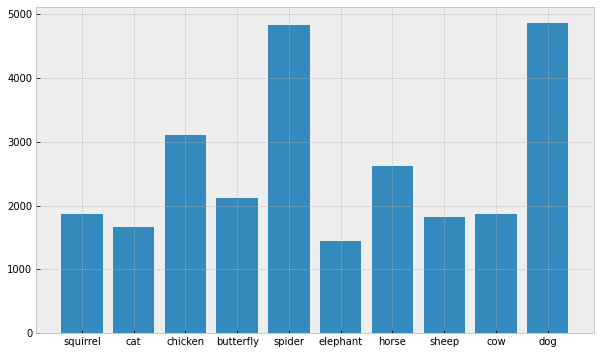

Total de elementos: 26179


In [9]:
# Visualização da distribuição de classes
class_names = os.listdir(IMG_DIR_PATH)
class_sizes = []
for class_name in class_names:
    class_sizes.append(len(os.listdir(IMG_DIR_PATH + class_name)))
class_names = list(map(translation_mapper.get, class_names))
plt.figure(figsize=(10,6))
x = np.arange(len(class_names))
plt.bar(x, class_sizes)
plt.xticks(x, class_names)
plt.show()
print("Total de elementos: {}".format(np.sum(class_sizes)))

In [10]:
# Para manipulação dos dados
SEED = 16
IMAGE_SIZE = (224, 224)
load_dataset = lambda subset, split: tf.keras.utils.image_dataset_from_directory (
    IMG_DIR_PATH,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    subset=subset, 
    validation_split=split, 
)
train_data = load_dataset("training", 0.2)
val_data = load_dataset("validation", 0.2)
train_size = len(train_data.file_paths)
test_size = int(len(val_data.file_paths)/2)
test_data = val_data.take(test_size)
val_data.skip(test_size)
val_size = test_size
print("\nUsing {}, {} and {} files for training, validation and test respectively.".format(train_size, val_size, test_size))

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.

Using 20944, 2617 and 2617 files for training, validation and test respectively.


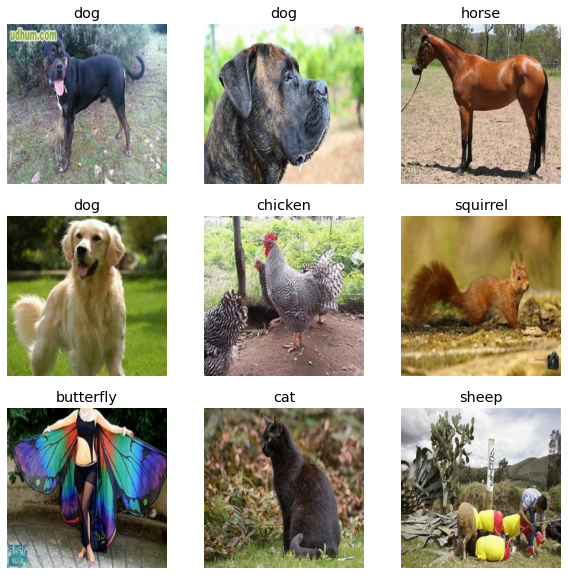

In [11]:
# Exemplo de imagens (possivelmente distorcidas devido ao redimensionamento)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_unmapper[int(labels[i])])
        plt.axis("off")

# Treinamento dos modelos

In [43]:
# Função de perda e otimizador a serem utilizados
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam, SGD

# Para mapeamento
DENSE = "d"
CONVOLUTIONAL = "c"
XCEPTION = "x"
RESNET50 = "r"
INCEPTIONV3 = "i"

# Para guardas os resultados
results = {}

# Caminhos para os modelos salvos
model_paths = {
    DENSE: "./models/dense_model.h5",
    CONVOLUTIONAL: "./models/conv_model.h5", 
    XCEPTION: "./models/xception_model.h5", 
    RESNET50: "./models/resnet50.h5", 
    INCEPTIONV3: "./models/inceptionv3_model.h5", 
}
model_backup_paths = {
    DENSE: "./models/backups/dense_model.h5",
    CONVOLUTIONAL: "./models/backups/conv_model.h5", 
    XCEPTION: "./models/backups/xception_model.h5", 
    RESNET50: "./models/backups/resnet50.h5", 
    INCEPTIONV3: "./models/backups/inceptionv3_model.h5", 
}

# Tensor de entrada
input_tensor = keras.layers.Input(shape=(*IMAGE_SIZE, 3))

# Quantia de classes
num_classes = len(label_mapper)

## Baseline: RNA densa

In [18]:
# Camadas necessárias
from keras.layers import Input, Flatten, Dense

# Criação do modelo
def create_dense_model(input_tensor, num_labels, loss, optimizer, name="model"):

    # Entrada
    inputs = input_tensor

    # Camadas Densas
    x = Flatten()(inputs[:,:,0]) # Para não explodir a memória: uso do primeiro canal somente
    x = Dense(units=256, activation="relu")(x)
    x = Dense(units=128, activation="relu")(x)
    x = Dense(units=64, activation="relu")(x)
    outputs = Dense(units=num_labels, activation="softmax")(x)

    # Finalização
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Modelo Denso
dense_model = None
if not os.path.exists(model_paths[DENSE]):
    loss_function = SparseCategoricalCrossentropy()
    model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
    dense_model = create_dense_model(input_tensor, num_classes, loss_function, model_optimizer, name="dense_model")
else:
    dense_model = load_model(model_paths[DENSE])

# Sumarização
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 3)           0         
 licingOpLambda)                                                 
                                                                 
 flatten (Flatten)           (None, 672)               0         
                                                                 
 dense (Dense)               (None, 256)               172288    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                       

In [29]:
# Treino
epochs = 4
dense_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
    steps_per_epoch=128, 
)
save_model(dense_model, model_backup_paths[DENSE])

Epoch 1/4
128/128 [==============================] - 14s 108ms/step - loss: 1.9897 - accuracy: 0.2727 - val_loss: 2.0839 - val_accuracy: 0.2567
Epoch 2/4
128/128 [==============================] - 13s 100ms/step - loss: 1.9731 - accuracy: 0.2703 - val_loss: 2.0923 - val_accuracy: 0.2573
Epoch 3/4
128/128 [==============================] - 13s 101ms/step - loss: 1.9861 - accuracy: 0.2800 - val_loss: 2.0763 - val_accuracy: 0.2619
Epoch 4/4
128/128 [==============================] - 14s 109ms/step - loss: 1.9843 - accuracy: 0.2817 - val_loss: 2.0645 - val_accuracy: 0.2537


In [67]:
# Teste
results[DENSE] = dense_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[DENSE][0], results[DENSE][1] * 100.0))

164/164 [==============================] - 7s 40ms/step - loss: 2.0645 - accuracy: 0.2537
loss = 2.06; accuracy = 25.37%


In [31]:
# Salvar modelo
save_model(dense_model, model_paths[DENSE])

## Modelo Convolucional

In [22]:
# Camadas necessárias
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Criação do modelo
def create_conv_model(input_tensor, num_labels, loss, optimizer, name="model"):

    # Entrada
    inputs = input_tensor

    # Primeira seção
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(32,kernel_size=(3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Segunda seção
    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Seção final
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_labels)(x)
    outputs = Activation(tf.nn.softmax)(x)

    # Finalização
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Modelo convolucional
conv_model = None
if not os.path.exists(model_paths[CONVOLUTIONAL]):
    loss_function = SparseCategoricalCrossentropy()
    model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
    conv_model = create_conv_model(input_tensor, num_classes, loss_function, model_optimizer, name="conv_model")
else:
    conv_model = load_model(model_paths[CONVOLUTIONAL])

# Sumarização
conv_model.summary()

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [33]:
# Treino
epochs = 2
conv_model.fit (
    train_data, 
    validation_data = val_data, 
    epochs = epochs, 
    steps_per_epoch = 256, 
)
save_model(conv_model, model_backup_paths[CONVOLUTIONAL])

Epoch 1/2
256/256 [==============================] - 46s 176ms/step - loss: 0.2265 - accuracy: 0.9236 - val_loss: 2.0302 - val_accuracy: 0.6078
Epoch 2/2
256/256 [==============================] - 45s 175ms/step - loss: 0.2423 - accuracy: 0.9261 - val_loss: 1.9239 - val_accuracy: 0.5966


In [65]:
# Teste
results[CONVOLUTIONAL] = conv_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[CONVOLUTIONAL][0], results[CONVOLUTIONAL][1] * 100.0))

164/164 [==============================] - 9s 54ms/step - loss: 1.9239 - accuracy: 0.5966
loss = 1.92; accuracy = 59.66%


In [35]:
# Salvar modelo
save_model(conv_model, model_paths[CONVOLUTIONAL])

## Modelos pré-definidos

In [38]:
# Camadas necessárias para a transferência de aprendizado
from keras.layers import Dense, GlobalAveragePooling2D

# Modelos originais
from keras.applications.xception import Xception
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

# Pré-processamento
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.applications.resnet import preprocess_input as resnet_preprocess_input
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input

### Xception

In [39]:
# Mapeamento dos conjuntos
def xception_preprocess_dataset(images, labels): 
    return xception_preprocess_input(images), labels
xception_train_data = train_data.map(xception_preprocess_dataset)
xception_val_data = val_data.map(xception_preprocess_dataset)
xception_test_data = test_data.map(xception_preprocess_dataset)

#### Nova arquitetura Xception

In [40]:
# Modelo original
base_model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Adição de camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Novo modelo
xception_model = Model(inputs=base_model.input, outputs=outputs)

# Congelamento das camadas convolucionais (para treinar somente as últimas superiores)
for layer in base_model.layers:
    layer.trainable = False

# Compilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
xception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
# Treino das camadas superiores
epochs = 4
xception_model.fit (
    xception_train_data, 
    validation_data = xception_val_data, 
    epochs = epochs, 
    #steps_per_epoch=128, 
)
save_model(xception_model, model_backup_paths[XCEPTION])

In [ ]:
# Visualização das camadas (para escolher até onde descongelar)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [44]:
# Descongelamento das orimeiras camadas
for layer in xception_model.layers[:105]:
   layer.trainable = False
for layer in xception_model.layers[105:]:
   layer.trainable = True

# Recompilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
xception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

# Treino
epochs = 4
xception_model.fit (
    xception_train_data, 
    validation_data = xception_val_data, 
    epochs = epochs, 
)
save_model(xception_model, model_backup_paths[XCEPTION])

Epoch 1/4
655/655 [==============================] - 150s 224ms/step - loss: 0.1560 - accuracy: 0.9677 - val_loss: 0.1305 - val_accuracy: 0.9635
Epoch 2/4
655/655 [==============================] - 145s 221ms/step - loss: 0.1119 - accuracy: 0.9732 - val_loss: 0.1186 - val_accuracy: 0.9660
Epoch 3/4
655/655 [==============================] - 145s 221ms/step - loss: 0.0970 - accuracy: 0.9759 - val_loss: 0.1118 - val_accuracy: 0.9675
Epoch 4/4
655/655 [==============================] - 140s 214ms/step - loss: 0.0872 - accuracy: 0.9768 - val_loss: 0.1075 - val_accuracy: 0.9685


#### Carregamento de um modelo Xception

In [ ]:
# Carregamento do modelo
xception_model = load_model(model_paths[XCEPTION])

In [ ]:
# Treino
epochs = 1
xception_model.fit (
    xception_train_data, 
    validation_data = xception_val_data, 
    epochs = epochs, 
)
save_model(xception_model, model_backup_paths[XCEPTION])

#### Teste da Xception

In [45]:
# Teste
results[XCEPTION] = xception_model.evaluate(xception_test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[XCEPTION][0], results[XCEPTION][1] * 100.0))

164/164 [==============================] - 22s 131ms/step - loss: 0.1075 - accuracy: 0.9685
loss = 0.11; accuracy = 96.85%


In [46]:
# Salvar modelo
save_model(xception_model, model_paths[XCEPTION])

### ResNet50

In [47]:
# Mapeamento dos conjuntos
def resnet_preprocess_dataset(images, labels): 
    return resnet_preprocess_input(images), labels
resnet_train_data = train_data.map(resnet_preprocess_dataset)
resnet_val_data = val_data.map(resnet_preprocess_dataset)
resnet_test_data = test_data.map(resnet_preprocess_dataset)

#### Nova arquitetura ResNet50

In [48]:
# Modelo original
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Adição de camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Novo modelo
resnet_model = Model(inputs=base_model.input, outputs=outputs)

# Congelamento das camadas convolucionais (para treinar somente as últimas camadas)
for layer in base_model.layers:
    layer.trainable = False

# Compilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
resnet_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


In [49]:
# Treino das camadas superiores
for _ in range(3):
    epochs = 4
    resnet_model.fit (
        resnet_train_data, 
        validation_data = resnet_val_data, 
        epochs = epochs, 
        steps_per_epoch=128,
    )
save_model(resnet_model, model_backup_paths[RESNET50])

Epoch 1/4
128/128 [==============================] - 46s 312ms/step - loss: 0.3083 - accuracy: 0.9087 - val_loss: 0.1548 - val_accuracy: 0.9572
Epoch 2/4
128/128 [==============================] - 34s 267ms/step - loss: 0.1823 - accuracy: 0.9473 - val_loss: 0.1640 - val_accuracy: 0.9549
Epoch 3/4
128/128 [==============================] - 35s 272ms/step - loss: 0.1922 - accuracy: 0.9497 - val_loss: 0.1373 - val_accuracy: 0.9610
Epoch 4/4
128/128 [==============================] - 34s 267ms/step - loss: 0.1823 - accuracy: 0.9492 - val_loss: 0.1471 - val_accuracy: 0.9585
Epoch 1/4
128/128 [==============================] - 35s 274ms/step - loss: 0.0998 - accuracy: 0.9700 - val_loss: 0.1387 - val_accuracy: 0.9599
Epoch 2/4
128/128 [==============================] - 36s 281ms/step - loss: 0.0837 - accuracy: 0.9746 - val_loss: 0.1421 - val_accuracy: 0.9620
Epoch 3/4
128/128 [==============================] - 34s 268ms/step - loss: 0.1026 - accuracy: 0.9692 - val_loss: 0.1608 - val_accuracy:

In [ ]:
# Visualização das camadas (para escolher até onde descongelar)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [50]:
# Descongelamento das orimeiras camadas
for layer in resnet_model.layers[:154]:
   layer.trainable = False
for layer in resnet_model.layers[154:]:
   layer.trainable = True

# Recompilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
resnet_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

# Treino
epochs = 6
resnet_model.fit (
    resnet_train_data, 
    validation_data = resnet_val_data, 
    epochs = epochs, 
)
save_model(resnet_model, model_backup_paths[RESNET50])

Epoch 1/6
655/655 [==============================] - 106s 156ms/step - loss: 0.0509 - accuracy: 0.9856 - val_loss: 0.1280 - val_accuracy: 0.9683
Epoch 2/6
655/655 [==============================] - 101s 154ms/step - loss: 0.0355 - accuracy: 0.9904 - val_loss: 0.1252 - val_accuracy: 0.9683
Epoch 3/6
655/655 [==============================] - 102s 155ms/step - loss: 0.0287 - accuracy: 0.9932 - val_loss: 0.1234 - val_accuracy: 0.9687
Epoch 4/6
655/655 [==============================] - 101s 153ms/step - loss: 0.0242 - accuracy: 0.9948 - val_loss: 0.1229 - val_accuracy: 0.9683
Epoch 5/6
655/655 [==============================] - 101s 154ms/step - loss: 0.0222 - accuracy: 0.9953 - val_loss: 0.1228 - val_accuracy: 0.9691
Epoch 6/6
655/655 [==============================] - 100s 152ms/step - loss: 0.0196 - accuracy: 0.9962 - val_loss: 0.1228 - val_accuracy: 0.9691


#### Carregamento de um modelo ResNet50

In [ ]:
# Carregamento do modelo
resnet_model = load_model(model_paths[RESNET50])

In [53]:
# Treino
for i in range(3):
    epochs = 4
    resnet_model.fit (
        resnet_train_data, 
        validation_data = resnet_val_data, 
        epochs = epochs, 
        steps_per_epoch=128,
    )
save_model(resnet_model, model_backup_paths[RESNET50])

Epoch 1/4
128/128 [==============================] - 36s 280ms/step - loss: 0.0125 - accuracy: 0.9980 - val_loss: 0.1224 - val_accuracy: 0.9691
Epoch 2/4
128/128 [==============================] - 37s 287ms/step - loss: 0.0126 - accuracy: 0.9990 - val_loss: 0.1223 - val_accuracy: 0.9689
Epoch 3/4
128/128 [==============================] - 35s 273ms/step - loss: 0.0087 - accuracy: 0.9993 - val_loss: 0.1223 - val_accuracy: 0.9689
Epoch 4/4
128/128 [==============================] - 34s 270ms/step - loss: 0.0116 - accuracy: 0.9978 - val_loss: 0.1216 - val_accuracy: 0.9691
Epoch 1/4
128/128 [==============================] - 37s 285ms/step - loss: 0.0104 - accuracy: 0.9995 - val_loss: 0.1216 - val_accuracy: 0.9689
Epoch 2/4
128/128 [==============================] - 35s 275ms/step - loss: 0.0119 - accuracy: 0.9988 - val_loss: 0.1219 - val_accuracy: 0.9687
Epoch 3/4
128/128 [==============================] - 35s 272ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.1221 - val_accuracy:

#### Teste da ResNet50

In [54]:
# Teste
results[RESNET50] = resnet_model.evaluate(test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[RESNET50][0], results[RESNET50][1] * 100.0))

164/164 [==============================] - 16s 97ms/step - loss: 0.3649 - accuracy: 0.9056
loss = 0.36; accuracy = 90.56%


In [55]:
# Salvar modelo
save_model(resnet_model, model_paths[RESNET50])

### InceptionV3

In [56]:
# Mapeamento dos conjuntos
def inception_preprocess_dataset(images, labels): 
    return inception_preprocess_input(images), labels
inception_train_data = train_data.map(inception_preprocess_dataset)
inception_val_data = val_data.map(inception_preprocess_dataset)
inception_test_data = test_data.map(inception_preprocess_dataset)

#### Nova arquitetura InceptionV3

In [57]:
# Modelo original
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Adição de camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Novo modelo
inception_model = Model(inputs=base_model.input, outputs=outputs)

# Congelamento das camadas convolucionais (para treinar somente as camadas superiores)
for layer in base_model.layers:
    layer.trainable = False

# Compilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0)
inception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

87910968/87910968 [==============================] - 5s 0us/step


In [58]:
# Treino das camadas superiores
for _ in range(3):
    epochs = 4
    inception_model.fit (
        inception_train_data, 
        validation_data = inception_val_data, 
        epochs = epochs, 
        steps_per_epoch=128,
    )
save_model(inception_model, model_backup_paths[INCEPTIONV3])

Epoch 1/4
128/128 [==============================] - 34s 217ms/step - loss: 0.3396 - accuracy: 0.9043 - val_loss: 0.2097 - val_accuracy: 0.9414
Epoch 2/4
128/128 [==============================] - 21s 167ms/step - loss: 0.1909 - accuracy: 0.9458 - val_loss: 0.1520 - val_accuracy: 0.9580
Epoch 3/4
128/128 [==============================] - 21s 168ms/step - loss: 0.1903 - accuracy: 0.9512 - val_loss: 0.2263 - val_accuracy: 0.9381
Epoch 4/4
128/128 [==============================] - 22s 169ms/step - loss: 0.1541 - accuracy: 0.9612 - val_loss: 0.1362 - val_accuracy: 0.9612
Epoch 1/4
128/128 [==============================] - 22s 173ms/step - loss: 0.1300 - accuracy: 0.9629 - val_loss: 0.1419 - val_accuracy: 0.9589
Epoch 2/4
128/128 [==============================] - 30s 239ms/step - loss: 0.1135 - accuracy: 0.9668 - val_loss: 0.1376 - val_accuracy: 0.9622
Epoch 3/4
128/128 [==============================] - 22s 172ms/step - loss: 0.1206 - accuracy: 0.9661 - val_loss: 0.1619 - val_accuracy:

In [ ]:
# Visualização das camadas (para escolher até onde descongelar)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [59]:
# Descongelamento das orimeiras camadas
for layer in inception_model.layers[:249]:
   layer.trainable = False
for layer in inception_model.layers[249:]:
   layer.trainable = True

# Recompilação
loss_function = SparseCategoricalCrossentropy()
model_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
inception_model.compile(optimizer=model_optimizer, loss=loss_function, metrics=['accuracy'])

# Treino
epochs = 8
inception_model.fit (
    inception_train_data, 
    validation_data = inception_val_data, 
    epochs = epochs, 
)
save_model(inception_model, model_backup_paths[INCEPTIONV3])

Epoch 1/8
655/655 [==============================] - 83s 120ms/step - loss: 0.1467 - accuracy: 0.9592 - val_loss: 0.1260 - val_accuracy: 0.9620
Epoch 2/8
655/655 [==============================] - 76s 116ms/step - loss: 0.1006 - accuracy: 0.9718 - val_loss: 0.1153 - val_accuracy: 0.9670
Epoch 3/8
655/655 [==============================] - 76s 116ms/step - loss: 0.0857 - accuracy: 0.9750 - val_loss: 0.1093 - val_accuracy: 0.9675
Epoch 4/8
655/655 [==============================] - 77s 117ms/step - loss: 0.0742 - accuracy: 0.9790 - val_loss: 0.1062 - val_accuracy: 0.9687
Epoch 5/8
655/655 [==============================] - 75s 115ms/step - loss: 0.0629 - accuracy: 0.9818 - val_loss: 0.1044 - val_accuracy: 0.9692
Epoch 6/8
655/655 [==============================] - 84s 127ms/step - loss: 0.0557 - accuracy: 0.9849 - val_loss: 0.1025 - val_accuracy: 0.9683
Epoch 7/8
655/655 [==============================] - 75s 114ms/step - loss: 0.0500 - accuracy: 0.9873 - val_loss: 0.1011 - val_accuracy:

#### Carregamento de um modelo InceptionV3

In [ ]:
# Carregamento do modelo
inception_model = load_model(model_paths[INCEPTIONV3])

In [60]:
# Treino
for _ in range(4):
    epochs = 3
    inception_model.fit (
        inception_train_data, 
        validation_data = inception_val_data, 
        epochs = epochs, 
        steps_per_epoch=256
    )
save_model(inception_model, model_backup_paths[INCEPTIONV3])

Epoch 1/3
256/256 [==============================] - 45s 176ms/step - loss: 0.0380 - accuracy: 0.9911 - val_loss: 0.1004 - val_accuracy: 0.9706
Epoch 2/3
256/256 [==============================] - 36s 142ms/step - loss: 0.0381 - accuracy: 0.9902 - val_loss: 0.1010 - val_accuracy: 0.9715
Epoch 3/3
143/256 [===============>..............] - ETA: 10s - loss: 0.0452 - accuracy: 0.9877

256/256 [==============================] - 26s 100ms/step - loss: 0.0452 - accuracy: 0.9877 - val_loss: 0.1007 - val_accuracy: 0.9706
Epoch 1/3
256/256 [==============================] - 45s 176ms/step - loss: 0.0349 - accuracy: 0.9921 - val_loss: 0.1005 - val_accuracy: 0.9706
Epoch 2/3
256/256 [==============================] - 38s 148ms/step - loss: 0.0347 - accuracy: 0.9912 - val_loss: 0.1007 - val_accuracy: 0.9715
Epoch 3/3
143/256 [===============>..............] - ETA: 10s - loss: 0.0443 - accuracy: 0.9868

256/256 [==============================] - 34s 134ms/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.1007 - val_accuracy: 0.9702
Epoch 1/3
256/256 [==============================] - 36s 141ms/step - loss: 0.0324 - accuracy: 0.9919 - val_loss: 0.1001 - val_accuracy: 0.9717
Epoch 2/3
256/256 [==============================] - 45s 176ms/step - loss: 0.0310 - accuracy: 0.9926 - val_loss: 0.1015 - val_accuracy: 0.9715
Epoch 3/3
143/256 [===============>..............] - ETA: 10s - loss: 0.0383 - accuracy: 0.9893

256/256 [==============================] - 26s 100ms/step - loss: 0.0383 - accuracy: 0.9893 - val_loss: 0.1013 - val_accuracy: 0.9704
Epoch 1/3
256/256 [==============================] - 37s 143ms/step - loss: 0.0291 - accuracy: 0.9935 - val_loss: 0.1010 - val_accuracy: 0.9708
Epoch 2/3
256/256 [==============================] - 37s 143ms/step - loss: 0.0287 - accuracy: 0.9932 - val_loss: 0.1013 - val_accuracy: 0.9717
Epoch 3/3
143/256 [===============>..............] - ETA: 11s - loss: 0.0374 - accuracy: 0.9901

256/256 [==============================] - 26s 103ms/step - loss: 0.0374 - accuracy: 0.9901 - val_loss: 0.1010 - val_accuracy: 0.9708


#### Teste da InceptionV3

In [61]:
# Teste
results[INCEPTIONV3] = inception_model.evaluate(inception_test_data)
print("loss = {:.2f}; accuracy = {:.2f}%".format(results[INCEPTIONV3][0], results[INCEPTIONV3][1] * 100.0))

164/164 [==============================] - 13s 76ms/step - loss: 0.1010 - accuracy: 0.9708
loss = 0.10; accuracy = 97.08%


In [62]:
# Salvar modelo
save_model(inception_model, model_paths[INCEPTIONV3])

# Resultados

In [79]:
# Preparação
numeric_results = np.array(list(results.values()))
labels = ["Dense", "Convolutional", "Xception", "ResNet50", "InceptionV3"]
x = np.arange(numeric_results.shape[0])

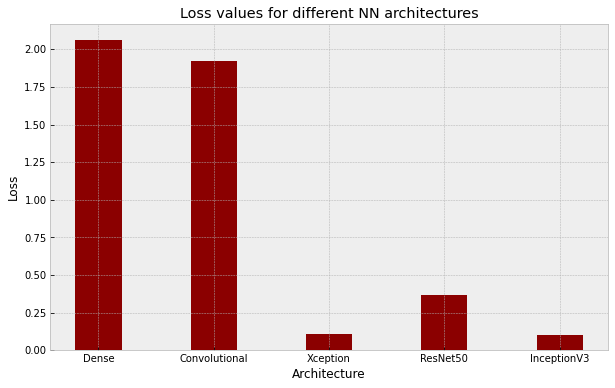

In [96]:
# Perda
plt.figure(figsize=(10,6))
plt.bar(x, numeric_results[:,0], 0.4, color='darkred')
plt.xticks(x, labels)
plt.xlabel("Architecture")
plt.ylabel("Loss")
plt.title("Loss values for different NN architectures")
plt.show()

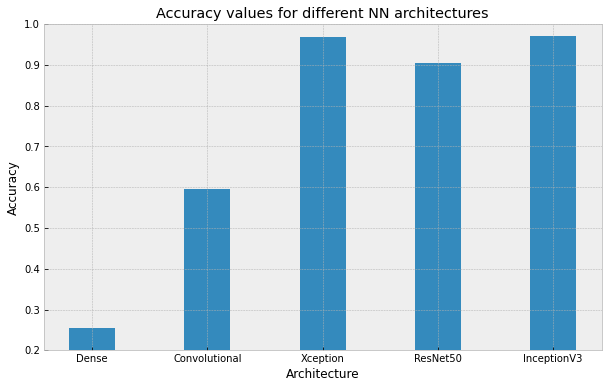

Accuracy values: [0.253, 0.596, 0.968, 0.905, 0.97]


In [107]:
# Acurácia
plt.figure(figsize=(10,6))
plt.bar(x, numeric_results[:,1], 0.4)
plt.xticks(x, labels)
plt.xlabel("Architecture")
plt.ylabel("Accuracy")
plt.ylim([0.2, 1.0])
plt.title("Accuracy values for different NN architectures")
plt.show()
accuracies = [float(str(acc)[:5]) for acc in numeric_results[:,1]]
print("Accuracy values:", accuracies)

Como esperado, por não se tratar de uma arquitetura adequada, a rede neural artificial (RNA) densamente conectada obteve o maior valor para a sua função de perda, enquanto que obtivera a menor das acurácias dentre os cinco modelos. Por sua vez, a RNA convolucional com poucas camadas obteve métricas melhores, tratando-se de uma arquitetura mais adequada ao problema em análise. Por fim, os três modelos convolucionais profundos, Xception, ResNet50 e InceptionV3 obtiveram os melhores resultados, que foram significativamente próximos entre si, ainda que a ResNet50 tenha perfomado um pouco pior do que as outras duas. 

A saber, estes três modelos apresentam 135, 178 e 314 camadas respectivamente, que receberam transferência de aprendizado por meio de novos treinamentos e ajustes-finos, finalizando o treinamento a partir do momento em que se notara falta de convergência. Em geral, a performance inferior da ResNet50, apesar de possuir mais camadas do que a Xception, pode decorrer de um ou mais dos seguintes fatores:


* Treinamento insuficiente;
* Hiperparâmetros mal-ajustados;
* Peculiaridades arquiteturais.

Ainda, alguns problemas com o conjunto de dados pode ter impedido as RNAs de terem alcançado valores ainda maiores de acurácia. Por exemplo, há um frango assado rotulado como um "frango" nesse conjunto, além de uma mulher com uma fantasia de borboleta rotulada como uma "borboleta" e fotos contendo diversos animais misturados. Além disso, as imagens do conjunto possuem dimensões irregulares, porém foram, todas, ajustadas para $224\times224$, o que pode ter acarretado perda e/ou deformação de informação.



# Visualização
Utiliza o modelo InceptionV3 com os pesos da Imagenet e, portanto, herdará os rótulos desse conjunto de dados. Esta seção objetiva apenas visualizar as escolhas de uma RNA convolucional e, de tal maneira, não requer um dos modelos treinados anteriormente.

96112376/96112376 [==============================] - 6s 0us/step


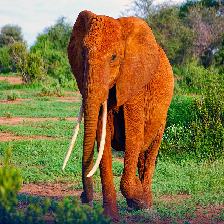

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.974542), ('n02504013', 'Indian_elephant', 0.017199399), ('n01871265', 'tusker', 0.008247838)]


In [108]:
# Dependências
from keras.applications.inception_v3 import decode_predictions, preprocess_input

# Imagem a ser utilizada
IMAGE_PATH = "./data/raw-img/elefante/e83cb60828f5043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg"

# Modelo auxiliar para visualizar as decisões
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet')
view_model = Model(inputs=base_model.inputs, outputs=base_model.layers[1].output)

# Imagem a ser utilizada
image = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=IMAGE_SIZE)
display(image)
image = tf.keras.preprocessing.image.img_to_array(image)
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
preds = base_model.predict(image)
print(decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 28ms/step


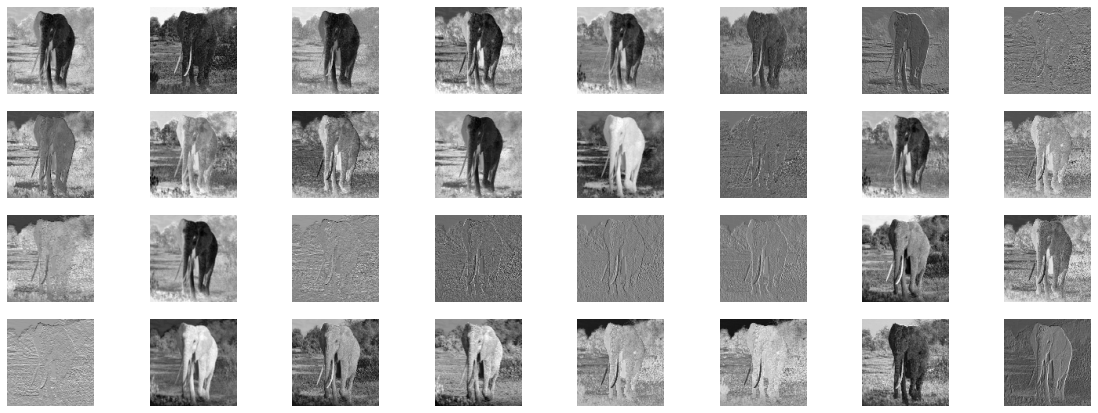

In [109]:
# Extração de características e visualização
features = view_model.predict(image)
fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
plt.show()

1/1 [==============================] - 1s 1s/step


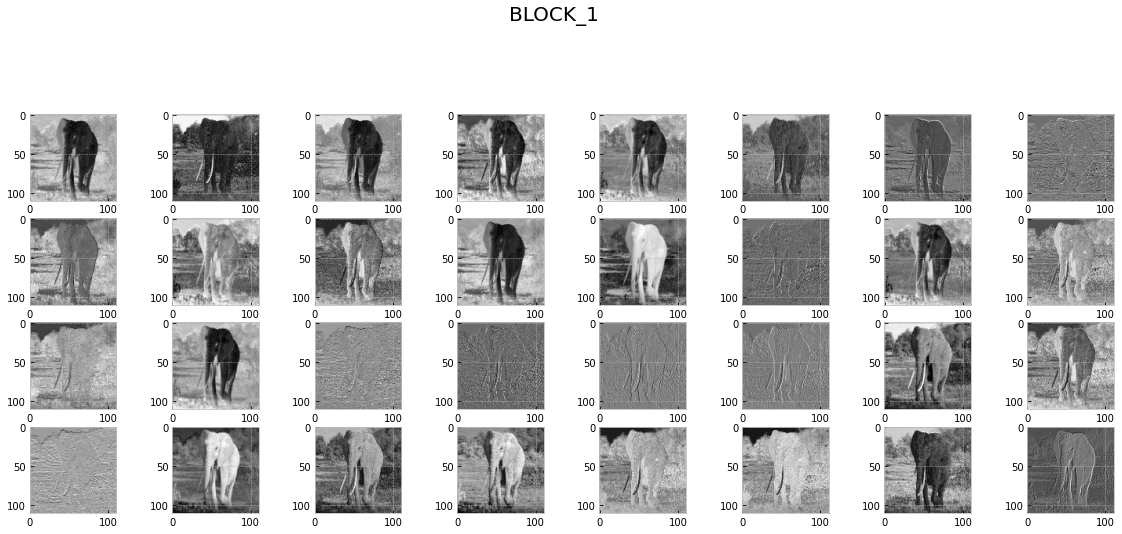

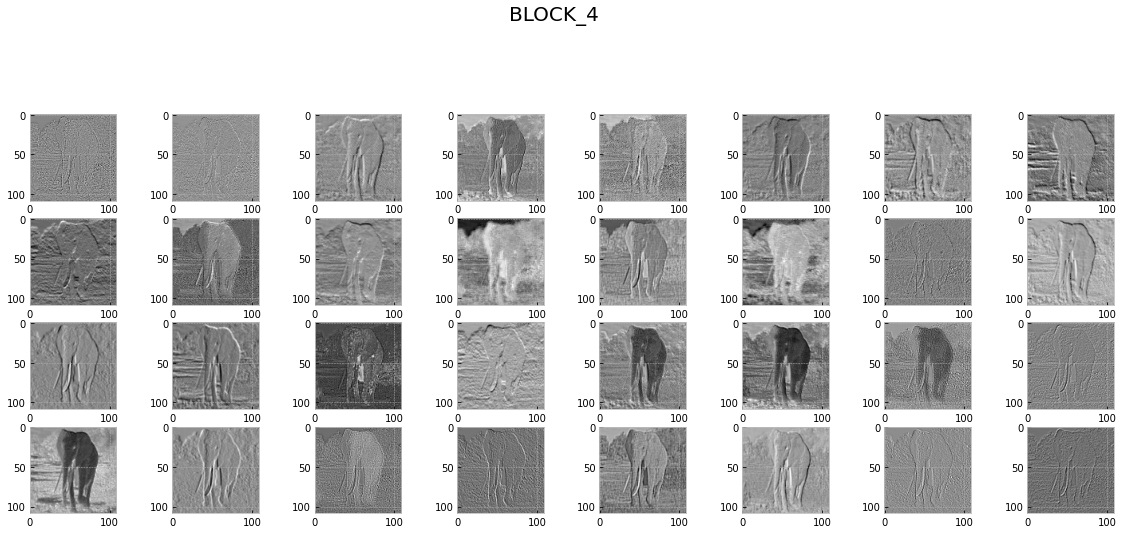

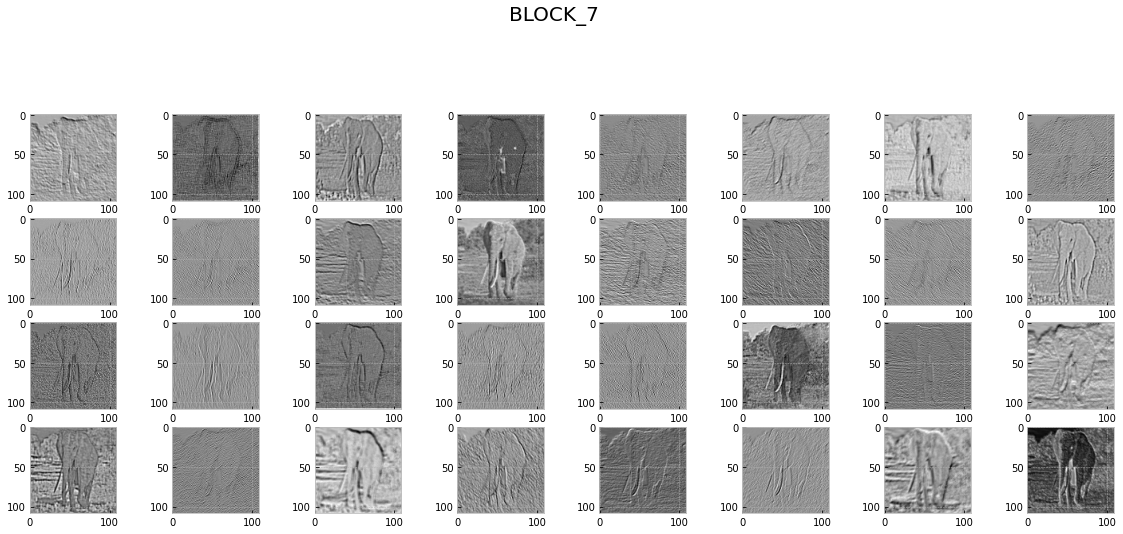

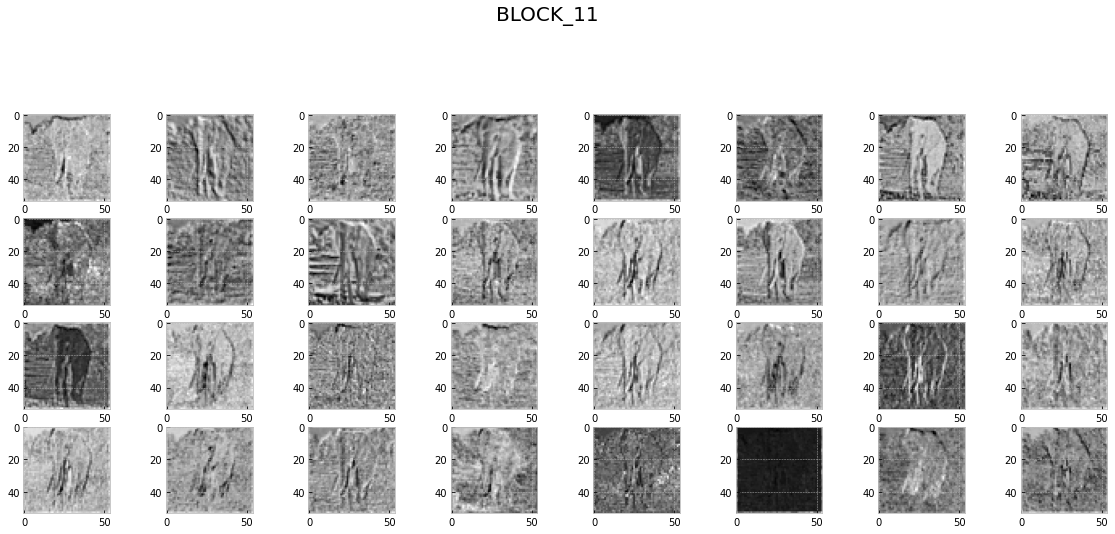

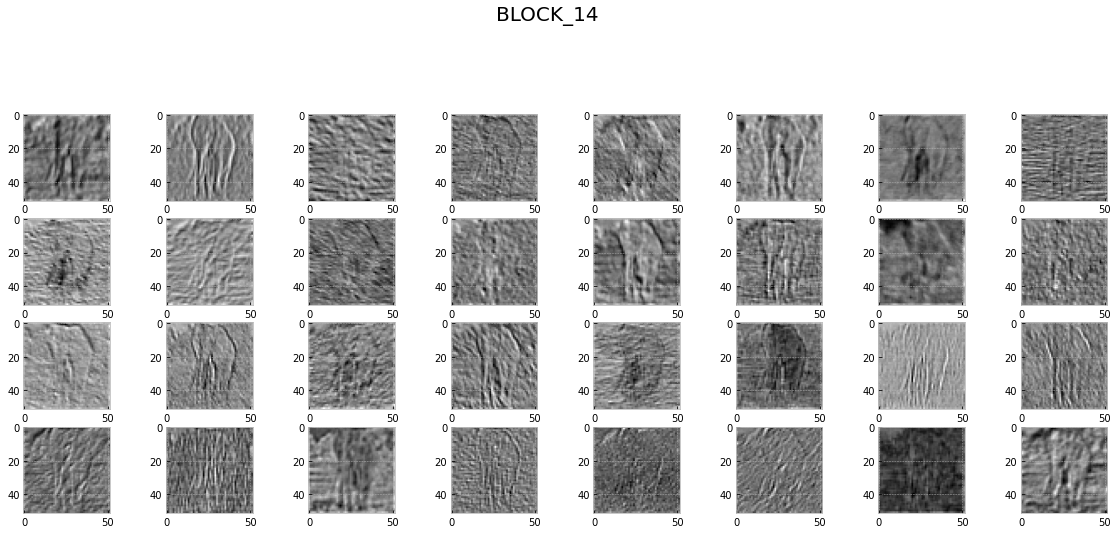

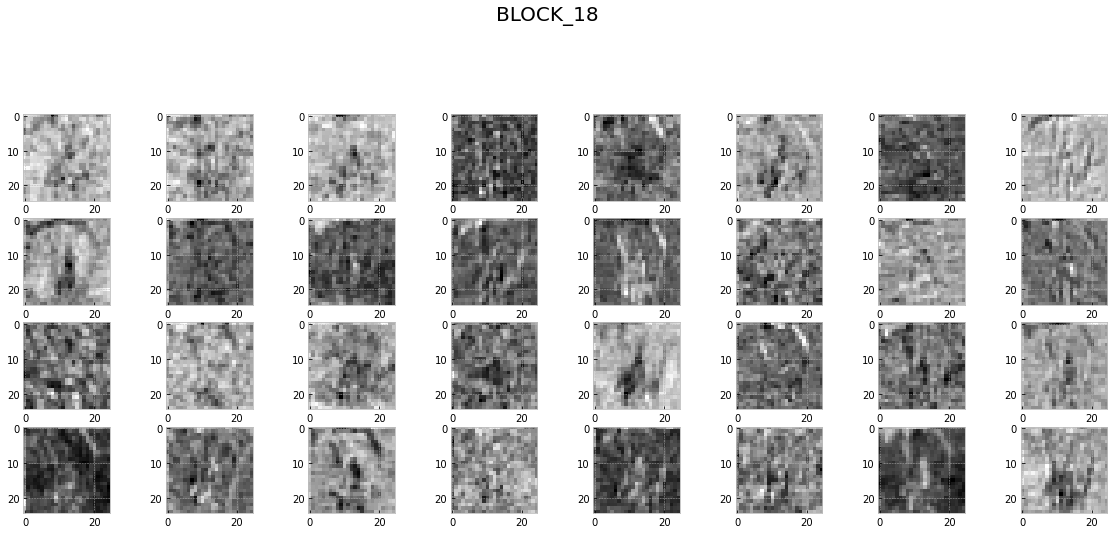

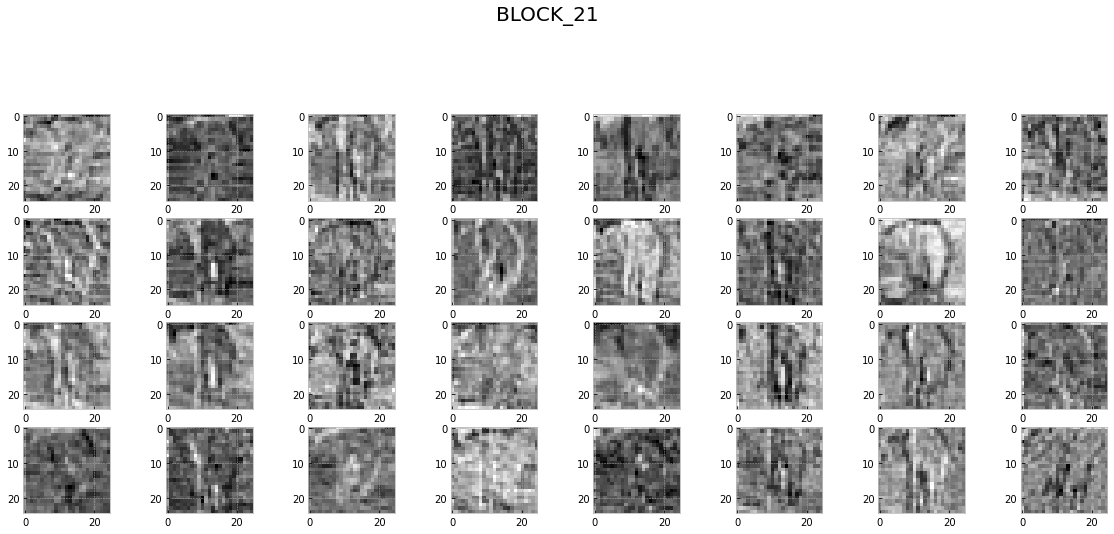

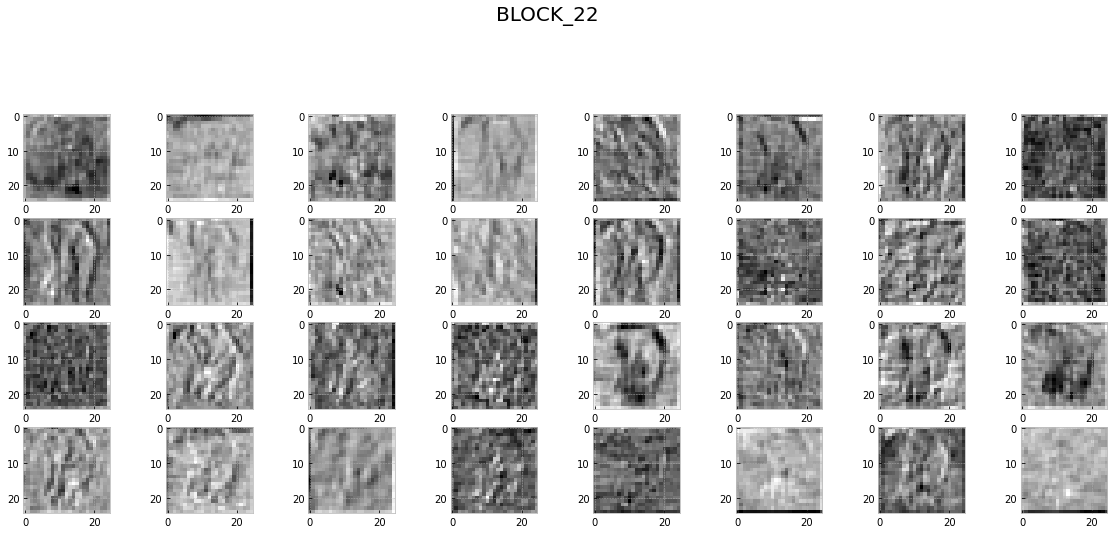

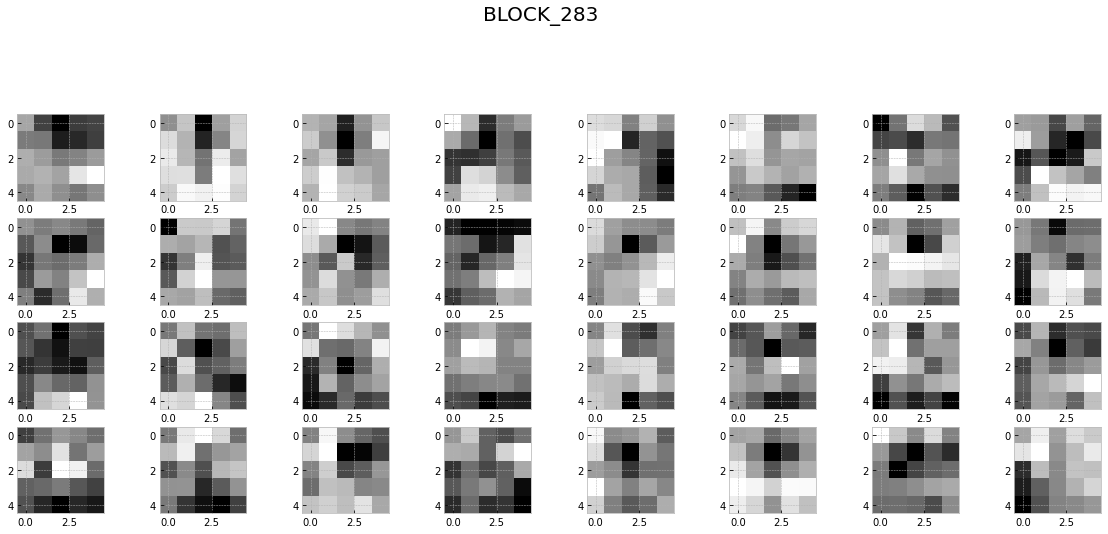

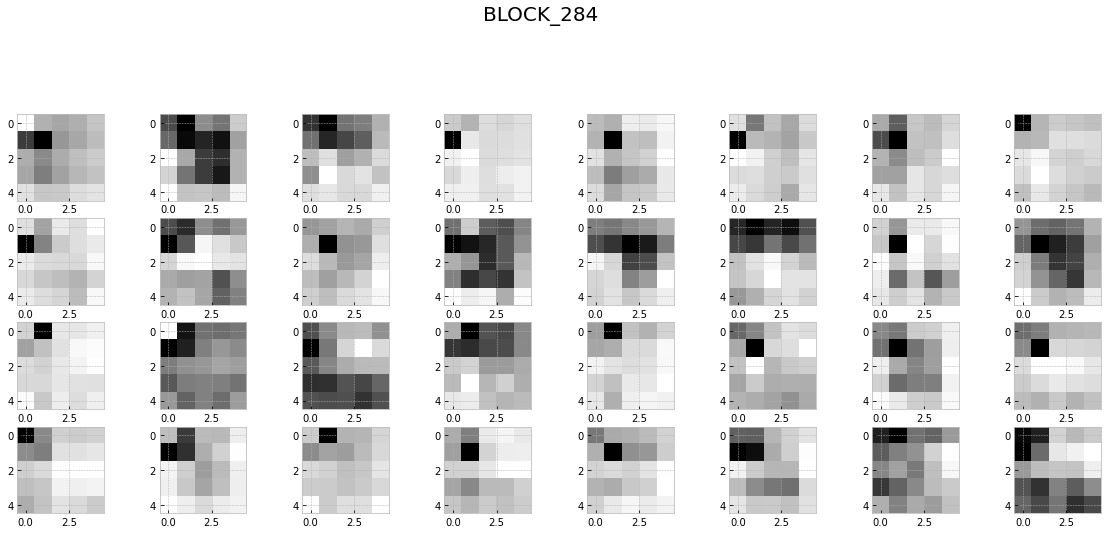

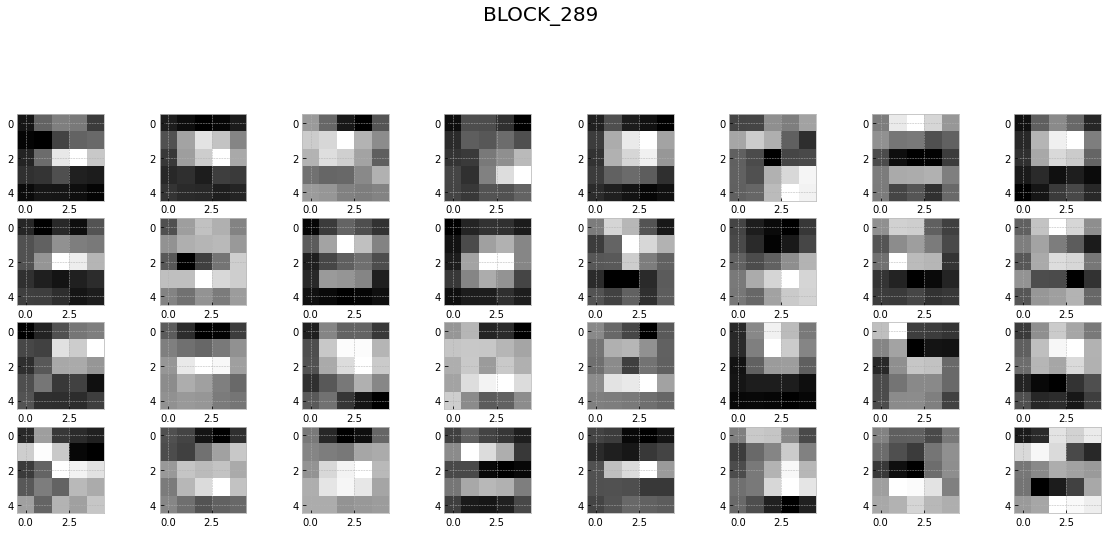

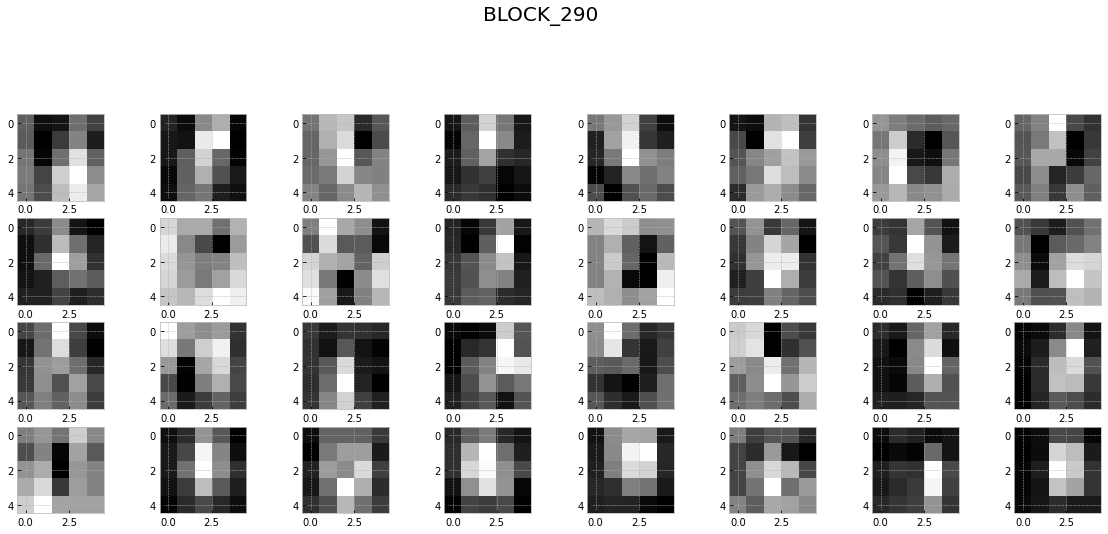

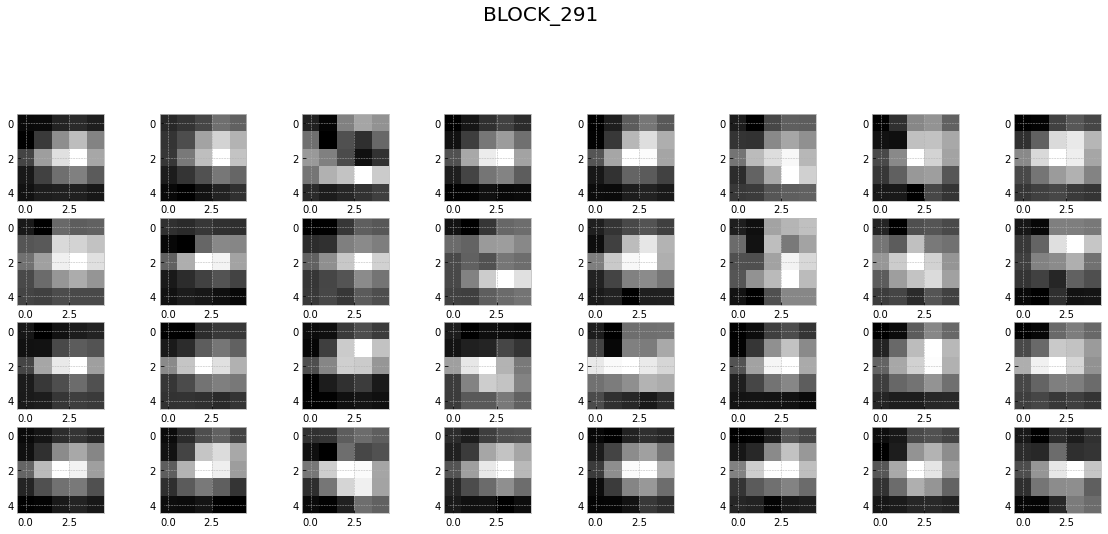

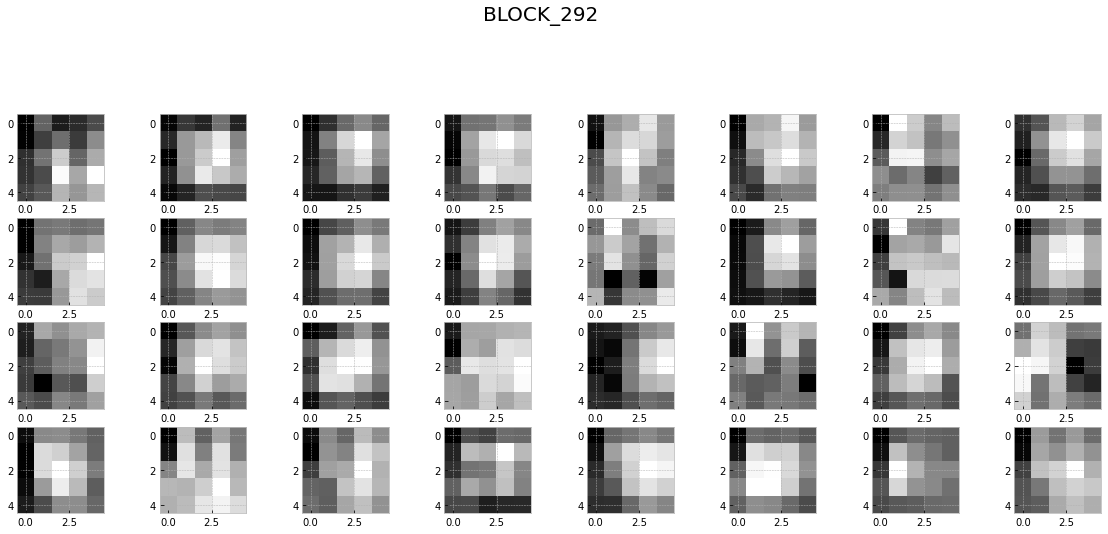

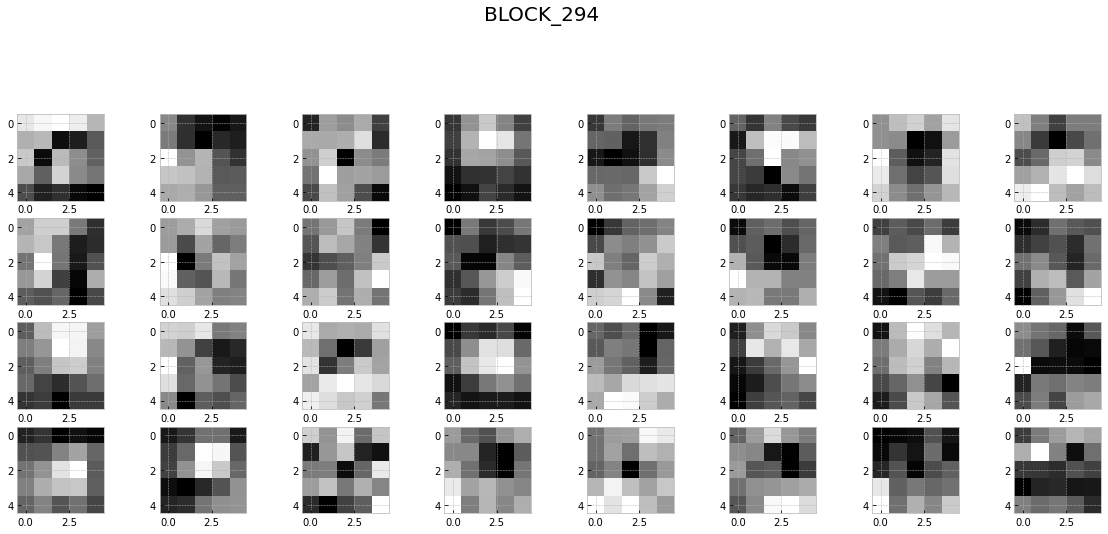

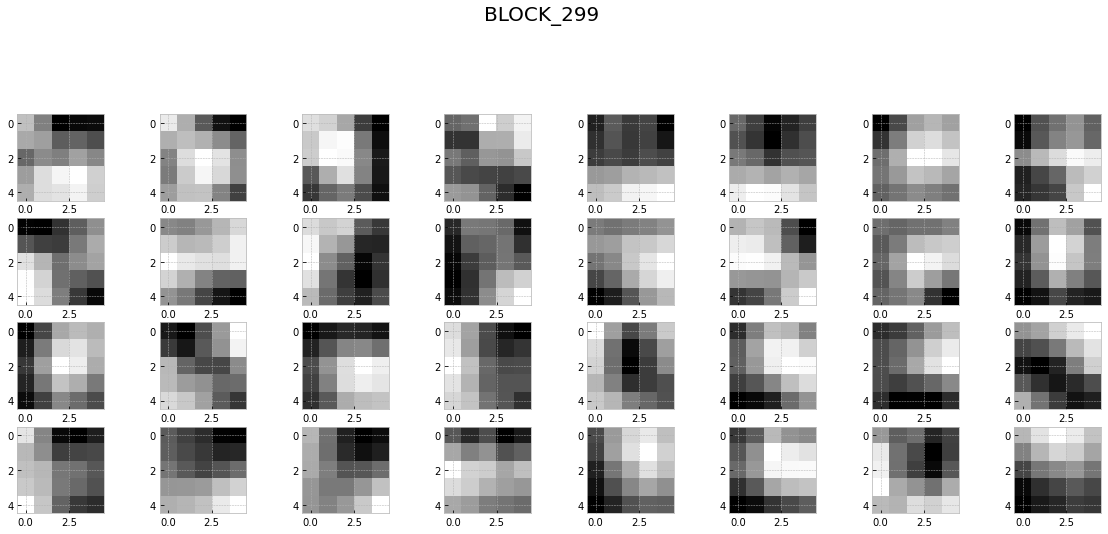

In [110]:
# Extração das camadas convolucionais e construção do modelo
conv_layers = []
for i, layer in enumerate(base_model.layers):
    if "conv" in layer.name:
        conv_layers.append(i)
head = conv_layers[:8] # Primeiras 8 camadas
tail = conv_layers[-8:] # Últimas 8 camadas
conv_layers = head + tail
outputs = [inception_model.layers[i].output for i in conv_layers]
view_model = Model(inputs=inception_model.inputs, outputs=outputs)

# Visualização
feature_map = view_model.predict(image)
for i, fmap in zip(conv_layers, feature_map):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')   
plt.show()